In [ ]:
import array
import functools
import gzip
import operator
import os
import struct
from tempfile import NamedTemporaryFile
from urllib.parse import urljoin
from urllib.request import urlretrieve

import numpy as np
from PIL import Image
from tqdm.notebook import tqdm as TQDM

In [ ]:
class IdxDecodeError(ValueError):
    """Raised when an invalid idx file is parsed."""
    pass


def parse_idx(fd):
    """Parse an IDX file, and return it as a numpy array.

    Parameters
    ----------
    fd : file
        File descriptor of the IDX file to parse

    endian : str
        Byte order of the IDX file. See [1] for available options

    Returns
    -------
    data : numpy.ndarray
        Numpy array with the dimensions and the data in the IDX file

    1. https://docs.python.org/3/library/struct.html
        #byte-order-size-and-alignment
    """
    DATA_TYPES = {0x08: 'B',  # unsigned byte
                  0x09: 'b',  # signed byte
                  0x0b: 'h',  # short (2 bytes)
                  0x0c: 'i',  # int (4 bytes)
                  0x0d: 'f',  # float (4 bytes)
                  0x0e: 'd'}  # double (8 bytes)

    header = fd.read(4)
    if len(header) != 4:
        raise IdxDecodeError('Invalid IDX file, '
                             'file empty or does not contain a full header.')

    zeros, data_type, num_dimensions = struct.unpack('>HBB', header)

    if zeros != 0:
        raise IdxDecodeError('Invalid IDX file, '
                             'file must start with two zero bytes. '
                             'Found 0x%02x' % zeros)

    try:
        data_type = DATA_TYPES[data_type]
    except KeyError:
        raise IdxDecodeError('Unknown data type '
                             '0x%02x in IDX file' % data_type)

    dimension_sizes = struct.unpack('>' + 'I' * num_dimensions,
                                    fd.read(4 * num_dimensions))

    data = array.array(data_type, fd.read())
    data.byteswap()  # looks like array.array reads data as little endian

    expected_items = functools.reduce(operator.mul, dimension_sizes)
    if len(data) != expected_items:
        raise IdxDecodeError('IDX file has wrong number of items. '
                             'Expected: %d. Found: %d' % (expected_items,
                                                          len(data)))

    return np.array(data).reshape(dimension_sizes)


In [ ]:
datasets_url = 'https://ossci-datasets.s3.amazonaws.com/mnist/'

def get_data(file : str):
    with NamedTemporaryFile("wb", suffix=".gz") as f:
        urlretrieve(
            urljoin(datasets_url, file),
            f.name   
        )
        with gzip.open(f.name, "rb") as zf:
            return parse_idx(zf)

def prepare_mnist_for_minitrainer(images, labels, what, max_count=None):
    label_count = {}
    for image, label in TQDM(zip(images, labels), desc="Writing MNIST dataset to disk...", total=len(images)):
        label_count[label] = label_count.get(label, -1) + 1
        if max_count is not None and label_count[label] > max_count:
            continue
        image_path = os.path.join("mnist", what, f'{label}', f'{label_count[label]}.png')
        os.makedirs(os.path.dirname(image_path), exist_ok=True)
        Image.fromarray(np.broadcast_to(image[:, :, np.newaxis], (*image.shape, 3))).save(image_path)

def prepare_train_mnist_for_minitrainer():
    train_images_file = 'train-images-idx3-ubyte.gz'
    train_labels_file = 'train-labels-idx1-ubyte.gz'

    train_labels = get_data(train_labels_file)
    train_images = get_data(train_images_file)

    prepare_mnist_for_minitrainer(train_images, train_labels, "train", 500)

def prepare_test_mnist_for_minitrainer():
    test_images_file = 't10k-images-idx3-ubyte.gz'
    test_labels_file = 't10k-labels-idx1-ubyte.gz'

    test_labels = get_data(test_labels_file)
    test_images = get_data(test_images_file)

    prepare_mnist_for_minitrainer(test_images, test_labels, "test", 500)

prepare_train_mnist_for_minitrainer()
prepare_test_mnist_for_minitrainer()

In [37]:
!cd mnist \
    && mt_train -i train --model efficientnet_b0 --batch_size 64 --epochs 5 --warmup_epochs 2 \
    && mt_predict -i test --class_index class_index.json --model efficientnet_b0 --weights efficientnet_b0_full_e5.pt --training_format

Building datasets with image size 256
Preprocessing validation images...: 100%|███| 513/513 [00:00<00:00, 1517.70it/s]
torch.Size([3, 256, 256])
Start training
Test:  Acc@1 27.096 Acc@5 71.150                                                
Epoch: [1]  [50/71]  eta: 0:00:02  lr: 8.605633802816899e-05  img/s: 496.5610768/home/asger/micromamba/envs/mini_trainer/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Test:  Acc@1 78.168 Acc@5 99.415                                                
Test:  Acc@1 91.033

In [38]:
import torch
from mini_trainer.builders import base_model_builder

device, dtype = torch.device("cuda:0"), torch.float32

model, mproc = base_model_builder(
    "efficientnet_b0",
    "mnist/efficientnet_b0_full_e5.pt",
    False,
    device,
    dtype,
    10
)
model.eval()
pass

## Manual inference with `mini_trainer` in Python

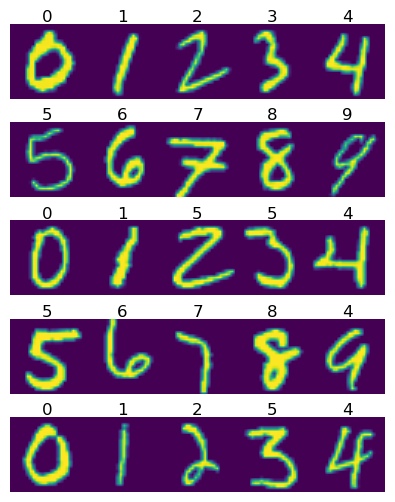

In [81]:
from matplotlib import pyplot as plt
from matplotlib.axes import Axes

from mini_trainer.predict import ImageLoader
from mini_trainer.utils import BaseResultCollector

images = [f"/home/asger/mini_trainer/examples/mnist/test/{i % 10}/{i}.png" for i in range(25)]
ds = ImageLoader(mproc, dtype, device)(images)

fig, axs = plt.subplots(5, 5, figsize=(3.75, 5))

for i, ax in enumerate(axs.flatten()):
    tim = ds[i]
    with torch.no_grad():
        prediction = model(tim.unsqueeze(0))
    if not isinstance(ax, Axes):
        raise TypeError()
    ax.matshow(tim.permute(1, 2, 0).cpu().mean(dim=2))
    ax.set_title(prediction.argmax().item(), pad=0, y=1.025)
    ax.axis("off")

plt.tight_layout(pad=0)
plt.show()

In [82]:
results = BaseResultCollector({i : f'{i}' for i in range(10)}, True)
images = [f"/home/asger/mini_trainer/examples/mnist/test/{(i + 1) % 10}/{i}.png" for i in range(500)]
ds = ImageLoader(mproc, dtype, device)(images)
for b in range(99):
    bis = list(range(b*5, b*5+5))
    with torch.no_grad():
        predictions = model(torch.stack([ds[i] for i in bis]))
    results.collect([images[i] for i in bis], predictions)
results.evaluate()

49|  |  |  |  |  |  |  |  |  
  |49|  |  |  |  |  | 1|  |  
 1|  |40|  |  | 9|  |  |  |  
  |  |  |46|  | 4|  |  |  |  
  |  |  |  |49|  |  |  |  | 1
  |  | 1| 5|  |42| 1| 1|  |  
 3|  | 3|  |  | 1|42|  |  |  
 1|  | 2| 2| 2| 1|  |41|  |  
  |  |  |  |  |  |  |  |49|  
 1|  | 1|  |  | 1| 1| 1| 5|39

Per-class Accuracies:
0___100.0% (49/49)
1____98.0% (49/50)
2____80.0% (40/50)
3____92.0% (46/50)
4____98.0% (49/50)
5____84.0% (42/50)
6____85.7% (42/49)
7____83.7% (41/49)
8___100.0% (49/49)
9____79.6% (39/49)

Micro Accuracy: 90.10% (446/495)
Macro Accuracy: 90.10%
